## SQL queries in Stack Exchange

In this note, I write down a SQL query to collect the dataset for users in Physics Stack Exchange.

Stack Exchange is a network of Q&A websites covering diverse topics. This website provides a convenient tool to query its database called Data Explorer. In this note, I collect the dataset for users in Physics Stack Exchange. One can make quires for Physics Stack Exchange database [here](https://data.stackexchange.com/physics/queries/new).

While the entire [database schema](https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede) contains numerous tables and columns, I focus on collecting data possibly used to measure the user activity level. For this, I collect a selection of columns from Users table, Posts table, and Badges table. Following is my SQL query:

```sql
WITH q AS (
  SELECT
    p.OwnerUserId,
    SUM(p.ViewCount) AS QuestionViews,
    SUM(p.Score) AS QuestionVotes,
    COUNT(p.OwnerUserId) AS Questions
  FROM Posts AS p
  WHERE PostTypeId=1
  GROUP BY p.OwnerUserId
),
a AS (
  SELECT
    p.OwnerUserId,
    COUNT(p.OwnerUserId) AS Answers
  FROM Posts AS p
  WHERE PostTypeId=2
  GROUP BY p.OwnerUserId
),
aa AS (
  SELECT p1.OwnerUserId, COUNT(p1.Id) AS AcceptedAnswers
  FROM Posts AS p1, Posts As p2
  WHERE p1.Id = p2.AcceptedAnswerId
  GROUP BY p1.OwnerUserId
),
gb AS (
  SELECT b.UserId, COUNT(b.Id) AS GoldBadges
  FROM Badges AS b
  WHERE b.Class=1
  GROUP BY b.UserId
),
sb AS (
  SELECT b.UserId, COUNT(b.Id) AS SilverBadges
  FROM Badges AS b
  WHERE b.Class=2
  GROUP BY b.UserId
),
bb AS (
  SELECT b.UserId, COUNT(b.Id) AS BronzeBadges
  FROM Badges AS b
  WHERE b.Class=3
  GROUP BY b.UserId
)

SELECT
  u.Id,
  u.Reputation,
  DATEDIFF(DAY,u.CreationDate,CURRENT_TIMESTAMP) AS DaysExisted,
  u.Views,
  u.UpVotes,
  u.DownVotes,
  ISNULL(q.QuestionViews,0) AS QuestionViews,
  ISNULL(q.QuestionVotes,0) AS QuestionVotes,
  ISNULL(q.Questions,0) AS Questions,
  ISNULL(a.Answers,0) AS Answers,
  ISNULL(aa.AcceptedAnswers,0) AS AcceptedAnswers,
  ISNULL(gb.GoldBadges,0) AS GoldBadges,
  ISNULL(sb.SilverBadges,0) AS SilverBadges,
  ISNULL(bb.BronzeBadges,0) AS BronzeBadges
FROM Users AS u
LEFT JOIN q
ON u.Id = q.OwnerUserId
LEFT JOIN a
ON u.Id = a.OwnerUserId
LEFT JOIN aa
ON u.Id = aa.OwnerUserId
LEFT JOIN gb
ON u.Id = gb.UserId
LEFT JOIN sb
ON u.Id = sb.UserId
LEFT JOIN bb
ON u.Id = bb.UserId
ORDER BY u.Reputation DESC
```

Result of this query can be downloaded in a csv file in Data Explorer. Data Explorer limits each query result to be up to 50000 rows. Here I sorted the dataset with respect to the reputation score, the dataset I created contains the data of 50000 Physics Exchange Users with the highest reputation scores.

To explore the created dataset, I present the first 10 rows of the dataset through pandas.

In [1]:
import pandas as pd

df=pd.read_csv("PhysicsExchangeUsers.csv")
df.head(10)

,Id,Reputation,DaysExisted,Views,UpVotes,DownVotes,QuestionViews,QuestionVotes,Questions,Answers,AcceptedAnswers,GoldBadges,SilverBadges,BronzeBadges
0,1325,309217,3676,77507,2993,2681,180561,1158,24,5823,2697,93,638,896
1,1492,197056,3670,41375,9421,139,8590,88,7,5730,1552,14,195,539
2,1236,166149,3678,88634,2014,918,37348,256,10,2187,1102,13,356,565
3,2451,141979,3623,85680,6426,7873,0,0,0,3061,1285,25,327,1680
4,8563,113455,3226,28487,9839,6245,203361,1840,144,2376,1154,28,271,552
5,26969,112802,2767,15058,2853,318,424,10,1,2591,1124,11,202,362
6,43351,92587,2509,8892,2211,1138,24685,243,28,1759,743,7,190,317
7,50583,89326,2428,36127,2888,20742,16336,262,18,1400,747,26,173,459
8,83398,85495,2068,14249,4658,2008,119562,1418,154,1006,469,21,221,357
9,520,81792,3735,23571,7630,4374,1595,42,5,1536,569,9,154,302


To be specific, each column represents:
* Id: User ID.
* Reputation: Reputation score. Calculation rule can be found in [here](https://stackoverflow.com/help/whats-reputation).
* DaysExisted: Number of days since the ID created.
* Views: Number of times the profile is viewd.
* UpVotes: Number of upvotes that the user has casted.
* DownVotes: Number of downvotes that the user has casted.
* QuestionViews: Sum of view counts of all questions that the user asked.
* QuestionVotes: Sum of (upvotes-downvotes) of all questions that the user asked.
* Questions: Number of questions that user asked.
* Answers: Number of answers that user posted.
* AccpetedAnswers: Number of the user's answers accepted by the question owners
* GoldBadges: Number of gold badges that the user obtained.
* SilverBadges: Number of silver badges that the user obtained.
* BronzeBadges: Number of bronze badges that the user obtained.

The statistical summary of each column is given by the following:

In [2]:
df.describe()

,Id,Reputation,DaysExisted,Views,UpVotes,DownVotes,QuestionViews,QuestionVotes,Questions,Answers,AcceptedAnswers,GoldBadges,SilverBadges,BronzeBadges
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,110202.606420,331.917220,1902.756940,57.795440,24.17684,4.350600,3731.18478,7.728380,2.368340,4.562080,1.425820,0.105300,1.089340,4.517800
std,81724.170283,2611.446987,934.458458,819.245469,214.37216,142.777756,18796.73236,36.349887,9.342319,59.077508,22.253783,0.758936,5.772645,12.710065
min,2.000000,101.000000,7.000000,0.000000,0.00000,0.000000,0.00000,-35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37968.750000,101.000000,1197.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,95418.000000,103.000000,1945.000000,2.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,173819.750000,155.000000,2573.000000,17.000000,6.00000,0.000000,1015.00000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,287505.000000,309217.000000,3751.000000,88634.000000,14960.00000,20742.000000,911178.00000,2473.000000,763.000000,5823.000000,2697.000000,93.000000,638.000000,1680.000000


The above data summary shows that the mean of each column is much larger than the median for the most of columns. That is, most of this data is right-skewed, i.e. most of the activity are made by relatively small number of enthusiasts. For example, Stack Exchange has the badge system to acknowledge users with high acitivity level. In the following, I plot the log-histogram of the gold badges (the rarest badges) counts. This plot shows how right-skewed this dataset is.

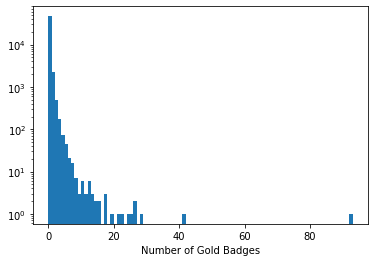

In [3]:
import matplotlib.pyplot as plt

plt.figure
plt.hist(df["GoldBadges"],bins=df["GoldBadges"].max(),log=True)
plt.xlabel("Number of Gold Badges");